##### Copyright 2019 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP Probabilistic Layers: Regression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this example we show how to fit regression models using TFP's "probabilistic layers."

### Dependencies & Prerequisites


In [100]:
#@title Import { display-mode: "form" }


from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions

### Make things Fast!

Before we dive in, let's make sure we're using a GPU for this demo.  

To do this, select "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> "GPU".

The following snippet will verify that we have access to a GPU.

In [101]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

Note: if for some reason you cannot access a GPU, this colab will still work. (Training will just take longer.)

## Motivation

Wouldn't it be great if we could use TFP to specify a probabilistic model then simply minimize the negative log-likelihood, i.e.,

In [102]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

Well not only is it possible, but this colab shows how! (In context of linear regression problems.)

In [103]:
#@title Synthesize dataset.
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

In [104]:
x

array([[-10.79563469],
       [ 28.72532314],
       [ -9.32872287],
       [ -0.7528304 ],
       [  6.17112446],
       [ 48.73099928],
       [ 33.28721705],
       [ 23.29297698],
       [-17.67889405],
       [ 38.6998637 ],
       [ 11.59600147],
       [ 44.16376949],
       [  0.35369007],
       [-15.44920507],
       [ 49.33189127],
       [ -2.31768033],
       [ 12.39915584],
       [  5.28771768],
       [-13.866984  ],
       [ 47.45797554],
       [ 47.91513182],
       [ 57.71720731],
       [ 10.83015315],
       [ 56.35905001],
       [ 15.66066887],
       [ 33.57797214],
       [-13.39999602],
       [ 51.7678864 ],
       [  3.84028006],
       [  0.98438581],
       [-19.58963607],
       [ 23.45620122],
       [ 18.04770936],
       [ 30.90989421],
       [ 58.25633073],
       [ 52.69302063],
       [ 52.81224606],
       [ 22.02045369],
       [-11.67848401],
       [ -5.52683238],
       [ 56.24321768],
       [ 12.95623867],
       [ 49.20136965],
       [ 33

In [105]:
n_examples = y.shape[0]

In [106]:
expectednegloglik = lambda y, rv_y: -rv_y.log_prob(y)/n_examples

### Case 1: MLE Linear Regression with Constant Uncertainty

In [107]:
# Build model.
input = tf.keras.layers.Input(1)
linear = tf.keras.layers.Dense(1)(input)
p = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))(linear)
model = tf.keras.Model(inputs=input, outputs=p)

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=expectednegloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

0.13475306
5.1279936


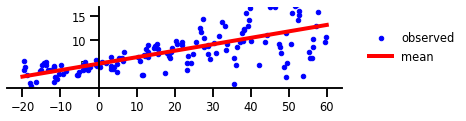

In [108]:

w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=[6, 1.5])  # inches
#plt.figure(figsize=[8, 5])  # inches
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig1.png', bbox_inches='tight', dpi=300)

### Case 2: MLE Linear Model with Homoscedastic Uncertainty

In [109]:
# Build model.
input = tf.keras.layers.Input(1)
linear = tf.keras.layers.Dense(1)(input)
s = tf.keras.layers.Dense(1, activation=tf.keras.activations.exponential,use_bias=False)(tf.constant(np.ones([1,1])))
p = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[0], scale=t[1]))([linear,s])
model = tf.keras.Model(inputs=input, outputs=p)

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=expectednegloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

0.13062835
5.1233163


In [110]:
yhat.stddev()

<tf.Tensor: shape=(150, 1), dtype=float32, numpy=
array([[1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.2234582],
       [1.

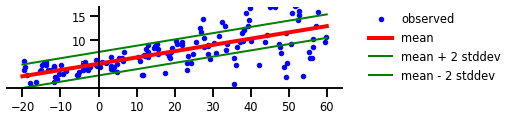

In [111]:

plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)

### Case 2: MLE Neural Network Regression with Heteroscedastic Uncertainty

In [112]:
# Build model.
input = tf.keras.layers.Input(1)
h1 = tf.keras.layers.Dense(10,activation=tf.keras.activations.relu)(input)
m = tf.keras.layers.Dense(1)(h1)
s = tf.keras.layers.Dense(1,activation=tf.keras.activations.exponential)(h1)
p = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[0], scale=t[1]))([m,s])
model = tf.keras.Model(inputs=input, outputs=p)

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=expectednegloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[-0.12012678 -0.22215377 -0.5754616  -0.4866096  -0.60830575 -0.2389222
 -0.05339454 -0.10379988 -0.25173917 -0.01664297]
[ 0.09975444  0.47372183 -0.09879512  0.10205274  0.10001115 -0.09927005
  0.07735351 -0.09827654 -0.09527447  2.1792197 ]
[ 0.6465339  -0.69758725 -0.3948502   0.52176344  0.2816731  -0.53920215
  0.72609884 -0.027995    0.79650307 -0.15815078]
0.10042015
[ 0.34788865  0.5026825  -0.5654655   0.00700354  0.17641284 -0.27258375
  0.69793034 -0.4444604  -0.5888244   1.6594968 ]
0.09807489


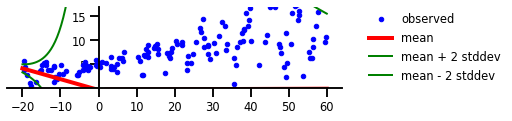

In [113]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)

### Case 3: MAP Neural Network Regression with Heteroscedastic Uncertainty

In [114]:
l2_reg = tf.keras.regularizers.l2(l2=0.0001)
# Build model.
input = tf.keras.layers.Input(1)
h1 = tf.keras.layers.Dense(100,activation=tf.keras.activations.relu,kernel_regularizer=l2_reg,bias_regularizer=l2_reg)(input)
m = tf.keras.layers.Dense(1,kernel_regularizer=l2_reg,bias_regularizer=l2_reg)(h1)
s = tf.keras.layers.Dense(1,activation=tf.keras.activations.exponential,kernel_regularizer=l2_reg,bias_regularizer=l2_reg)(h1)
p = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[0], scale=t[1]))([m,s])
model = tf.keras.Model(inputs=input, outputs=p)

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=expectednegloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[-8.61506907e-11  6.45087957e-02  3.11989170e-05  6.34623029e-06
 -8.05311091e-03  1.76387621e-04 -2.08326179e-04 -4.83703577e-10
  2.81299409e-02  3.31385224e-03 -2.59720683e-02 -3.97412069e-02
 -3.64109757e-04 -4.61423291e-08  5.40285558e-03 -4.43925819e-06
 -2.58598309e-02 -1.29199937e-01 -3.18981474e-03  7.78953545e-03
 -8.35545012e-04 -1.33802053e-02 -1.02385610e-01 -9.56954435e-04
 -1.34150288e-03  7.98528641e-02  1.35828517e-02 -5.08166113e-11
  4.97203879e-02 -8.20178597e-04 -7.43892795e-15 -1.56386250e-06
 -2.73673306e-03  8.44827667e-02 -1.13169532e-02 -6.20030984e-03
 -1.02056146e-01 -2.37559642e-11 -5.13352902e-11 -1.56780977e-10
 -1.05423125e-04  2.57107941e-03 -9.43028717e-04 -8.23971575e-08
 -1.16512366e-02 -6.68758005e-02 -1.81414420e-03 -2.08292878e-03
  5.45313247e-02 -6.46828610e-16 -1.82722439e-03  5.30610941e-06
 -3.35710487e-11  4.28676344e-02 -5.26846678e-04 -3.50436750e-07
 -2.84240231e-12 -3.29093146e-03  1.66397151e-02  1.70408580e-02
 -3.87706724e-03 -5.97590

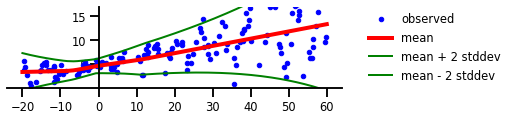

In [115]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)

### Case 4: Laplace Approximation Neural Network Regression with Heteroscedastic Uncertainty

In [116]:
import tensorflow as tf
import numpy as np
import math
class LaplaceApproximation(tf.keras.Model):

    def __init__(self,model):
        super().__init__()
        self.model = model
        self.mean = None
        self.std = None
        self.lam = None

    def fit(self,dataset,training=False):
        """
        Fit the Laplace approximation for a model. Setting the mean of the Laplace approximation to the weights of the model 
            and, using the diagonal of the Fisher matrix, set the standard deviation of the Laplace approximation.
        :param model: Model whose Fisher matrix is to be computed.
        :param dataset: Dataset which the model has been trained on, but which will not be seen in the future. 
            Formatted as (inputs, labels).
        :param samples: Number of samples to take from the dataset. More samples
            gives a better approximation of the true variance.
        """
        inputs, labels = dataset
        trainable_weights = self.model.trainable_weights
        variance = [tf.zeros_like(tensor) for tensor in trainable_weights]
        
        pb = tf.keras.utils.Progbar(inputs.shape[0])

        for i in range(inputs.shape[0]):
            pb.update(i)
            index = i#np.random.randint(len(inputs))
            # Select an element from the dataset.
            data = inputs[index]
            target = labels[index]

            # When extracting from the array we lost a dimension so put it back.
            data = tf.expand_dims(data, axis=0)

            # Collect gradients.
            with tf.GradientTape() as tape:
                output = self.model(data,training=training)
                log_likelihood = output.log_prob(target)

            gradients = tape.gradient(log_likelihood, trainable_weights)

            # If the model has converged, we can assume that the current weights
            # are the mean, and each gradient we see is a deviation. The variance is
            # the average of the square of this deviation.
            variance = [var + (grad ** 2) for var, grad in zip(variance, gradients)]

        self.fisher_diagonal = [tensor.numpy() for tensor in variance]
        #self.fisher_diagonal = [tensor.numpy() / samples * inputs.shape[0] for tensor in variance]
        
        mins = [np.min(f) for f in self.fisher_diagonal]
        for i,x in enumerate(mins):
          if i==0 or min > x:
            min = x
        print(min)
        #print('FISHER')
        #print(fisher_diagonal)
        self.mean = self.model.get_weights()       
        

    def reset_weights(self):
        if self.mean:
            self.model.set_weights(self.mean)

    def set_std(self, weight_decay):
      self.std = [np.reciprocal(np.sqrt(x+weight_decay)) for x in self.fisher_diagonal]

    def call(self, inputs, training=False):
        e = [np.random.standard_normal(x.shape) for x in self.mean]
        sample = [m+s*e for m, s, e in zip(self.mean,self.std,e)]
        self.model.set_weights(sample)
        return self.model(inputs,training=training)

In [117]:
la = LaplaceApproximation(model)

In [118]:
la.fit([x,y])

147/150 [============================>.] - ETA: 0s1.3668522e-33


In [119]:
la.set_std(100)

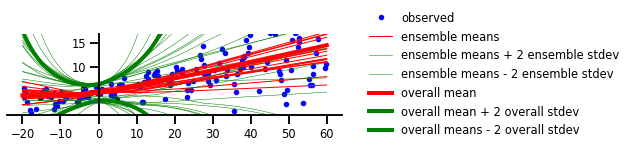

In [120]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

yhats = [la(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
ms = []
ss = []
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 15:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
    plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  ms += [m]
  ss += [s]
ms = np.array(ms)
avgm = ms.mean(axis=0)
ss = np.array(ss)
avgs = np.sqrt((ms**2+ss**2).mean(axis=0)-avgm**2)
plt.plot(x_tst, avgm, 'r', label='overall mean', linewidth=4)
plt.plot(x_tst, avgm + 2 * avgs, 'g', linewidth=4, label='overall mean + 2 overall stdev');
plt.plot(x_tst, avgm - 2 * avgs, 'g', linewidth=4, label='overall means - 2 overall stdev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig4.png', bbox_inches='tight', dpi=300)

### Case 5: MAP Neural Network Regression with Heteroscedastic Uncertainty and Parameter Pruning

In [121]:
lambda_prune= 0.83

In [122]:
W1_prune = model.trainable_weights[0] * tf.cast(tf.abs(model.trainable_weights[0]/la.std[0]) > lambda_prune,tf.float32)
b1_prune = model.trainable_weights[1] * tf.cast(tf.abs(model.trainable_weights[1]/la.std[1]) > lambda_prune,tf.float32)
W2_mu_prune = model.trainable_weights[2] * tf.cast(tf.abs(model.trainable_weights[2]/la.std[2]) > lambda_prune,tf.float32)
b2_mu_prune = model.trainable_weights[3] * tf.cast(tf.abs(model.trainable_weights[3]/la.std[3]) > lambda_prune,tf.float32)
W2_sig_prune = model.trainable_weights[4] * tf.cast(tf.abs(model.trainable_weights[4]/la.std[4]) > lambda_prune,tf.float32)
b2_sig_prune = model.trainable_weights[5] * tf.cast(tf.abs(model.trainable_weights[5]/la.std[5]) > lambda_prune,tf.float32)

In [123]:
trainable_weights_pruned = [W1_prune,b1_prune,W2_mu_prune,b2_mu_prune,W2_sig_prune,b2_sig_prune]

In [154]:
not_pruned = 0
pruned = 0
for w in trainable_weights_pruned:
  not_pruned += tf.reduce_sum(tf.cast(w!=0.,tf.float32))
  pruned += tf.reduce_sum(tf.cast(w==0.,tf.float32))
percent_pruned = (pruned/(pruned+not_pruned)).numpy()

In [155]:
percent_pruned

0.5099502

In [149]:
model_pruned = tf.keras.models.clone_model(model)

In [150]:
model_pruned.set_weights(trainable_weights_pruned)
yhat = model_pruned(x_tst)

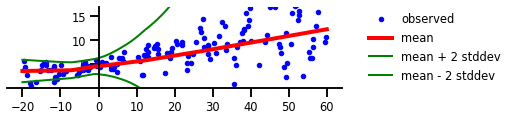

In [151]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)

In [129]:
#@title Synthesize New Dataset.
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(42)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y_2, x_2, x_tst_2 = load_dataset()

### MAP Neural Network Regression with Heteroscedastic Uncertainty and a Laplace Approximation Prior

In [130]:
class GaussianPriorRegularizer(tf.keras.regularizers.Regularizer):
  def __init__(self, loc, scale,n_examples):
    self.loc = loc
    self.scale= scale

  def __call__(self, x):
    return 0.5/float(n_examples) * tf.math.reduce_sum(tf.square(tf.math.reciprocal(self.scale)) * tf.math.square(x-self.loc))

  def get_config(self):
    return {'loc': self.loc, 'scale': self.scale}

In [131]:
W1_loc = model.trainable_weights[0]
b1_loc = model.trainable_weights[1]
W2_mu_loc = model.trainable_weights[2]
b2_mu_loc = model.trainable_weights[3]
W2_sig_loc = model.trainable_weights[4]
b2_sig_loc = model.trainable_weights[5]

In [132]:
W1_scale = la.std[0]
b1_scale = la.std[1]
W2_mu_scale = la.std[2]
b2_mu_scale = la.std[3]
W2_sig_scale = la.std[4]
b2_sig_scale = la.std[5]

In [133]:
reg_W1 = GaussianPriorRegularizer(loc=W1_loc,scale=W1_scale,n_examples=n_examples)
reg_b1 = GaussianPriorRegularizer(loc=b1_loc,scale=b1_scale,n_examples=n_examples)
reg_W2_mu = GaussianPriorRegularizer(loc=W2_mu_loc,scale=W2_mu_scale,n_examples=n_examples)
reg_b2_mu = GaussianPriorRegularizer(loc=b2_mu_loc,scale=b2_mu_scale,n_examples=n_examples)
reg_W2_sig = GaussianPriorRegularizer(loc=W2_sig_loc,scale=W2_sig_scale,n_examples=n_examples)
reg_b2_sig = GaussianPriorRegularizer(loc=b2_sig_loc,scale=b2_sig_scale,n_examples=n_examples)

In [134]:

# Build model.
input = tf.keras.layers.Input(1)
h1 = tf.keras.layers.Dense(100,activation=tf.keras.activations.relu,kernel_regularizer=reg_W1,bias_regularizer=reg_b1)(input)
m = tf.keras.layers.Dense(1,kernel_regularizer=reg_W2_mu,bias_regularizer=reg_W2_mu)(h1)
s = tf.keras.layers.Dense(1,activation=tf.keras.activations.exponential,kernel_regularizer=reg_W2_sig,bias_regularizer=reg_b2_sig)(h1)
p = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[0], scale=t[1]))([m,s])
model_2 = tf.keras.Model(inputs=input, outputs=p)

# Do inference.
model_2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=expectednegloglik)
model_2.fit(x_2, y_2, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat_2 = model_2(x_tst_2)
assert isinstance(yhat_2, tfd.Distribution)

[ 0.05916218  0.07743399  0.01005633  0.1351511   0.13374291  0.02035745
  0.01301698  0.0312241  -0.01890122  0.07383373  0.02743894 -0.04796959
  0.11188435  0.14525081 -0.01156635  0.03200342 -0.0156411  -0.08010915
 -0.07284796  0.059216    0.03638256  0.04651063 -0.11584144  0.0097851
 -0.02622386  0.07825387  0.06161001 -0.09949362  0.04214218  0.2318307
 -0.12449931 -0.09059707  0.01746687  0.08222549  0.05057219 -0.0311393
 -0.19439396  0.18193874 -0.14072874 -0.01146438  0.01569572  0.09969088
  0.03807338  0.07045716  0.17910294 -0.07187615 -0.12620915 -0.03446725
  0.07540539  0.02568623 -0.00576986  0.04615048  0.2065717   0.053888
  0.09332075 -0.05172975  0.00230633 -0.00722388  0.01817116  0.02177383
 -0.12218009 -0.07704797  0.10533066  0.04865688  0.01161567  0.20729299
  0.12916404  0.0496119  -0.05063994 -0.03700969 -0.0266222  -0.07855315
 -0.1667982   0.04613291 -0.04125399 -0.06164172 -0.02142069  0.14483683
  0.17059912 -0.08512633  0.073211   -0.08640821  0.0624

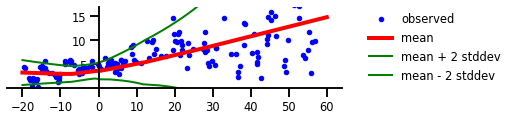

In [135]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x_2, y_2, 'b.', label='observed');

m = yhat_2.mean()
s = yhat_2.stddev()

plt.plot(x_tst_2, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst_2, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst_2, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)